In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  # 텐서플로가 첫 번째 GPU만 사용하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
    # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


# Setup

In [2]:
from __future__ import print_function, division

import tensorflow as tf
from tensorflow import keras 

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing import image_dataset_from_directory

from data_loader import DataLoader
from models import build_generator, build_discriminator, build_vgg

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

from IPython.display import display
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os

# Set seed for comparison

In [3]:
tf.random.set_seed(2)

# Prepare Dataset

In [4]:
channels = 3
lr_height = 64  # Low resolution height
lr_width = 64  # Low resolution width
lr_shape = (lr_height, lr_width, channels)
hr_height = lr_height * 4  # High resolution height
hr_width = lr_width * 4  # High resolution width
hr_shape = (hr_height, hr_width, channels)

# Number of residual blocks in the generator
n_residual_blocks = 16

dataset_name = 'img_align_celeba'

In [5]:
current_dir = os.getcwd()
root_dir = os.path.join(current_dir, 'datasets')
batch_size = 1
image_size = (hr_height, hr_width)

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=image_size,
    validation_split=0.2,
    subset="training",
    seed=1333,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=image_size,
    validation_split=0.2,
    subset="validation",
    seed=1333,
    label_mode=None,
)

Found 202599 files belonging to 2 classes.
Using 162080 files for training.
Found 202599 files belonging to 2 classes.
Using 40519 files for validation.


# Preprocessing

In [6]:
def scaling(input_image):
    input_image = input_image / 127.5 - 1.
    return input_image


# Scale from (0, 255) to (-1, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

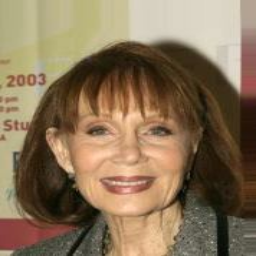

tf.Tensor(
[[[ 0.36470592  0.3411765   0.00392163]
  [ 0.37322307  0.34969366  0.01243877]
  [ 0.38412988  0.36060047  0.02334559]
  ...
  [ 0.41363358  0.27656245  0.15294123]
  [ 0.41176474  0.27843142  0.15294123]
  [ 0.41176474  0.27843142  0.15294123]]

 [[ 0.36470592  0.3411765   0.00392163]
  [ 0.37322307  0.34969366  0.01243877]
  [ 0.38412988  0.36060047  0.02334559]
  ...
  [ 0.41363358  0.27656245  0.15294123]
  [ 0.41176474  0.27843142  0.15294123]
  [ 0.41176474  0.27843142  0.15294123]]

 [[ 0.36470592  0.3411765   0.00392163]
  [ 0.37322307  0.34969366  0.01243877]
  [ 0.38412988  0.36060047  0.02334559]
  ...
  [ 0.41363358  0.27656245  0.15294123]
  [ 0.41176474  0.27843142  0.15294123]
  [ 0.41176474  0.27843142  0.15294123]]

 ...

 [[ 0.47475493  0.4041667   0.17089462]
  [ 0.48375452  0.41316628  0.17989421]
  [ 0.4941622   0.42004788  0.1916889 ]
  ...
  [-0.13020283 -0.1458891  -0.24187565]
  [-0.1372549  -0.15294117 -0.24705881]
  [-0.1372549  -0.15294117 -0.247

In [7]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))
        print(img)

In [8]:
def random_flip(input_image):
    if np.random.random() < 0.5:
        input_image = tf.image.flip_left_right(input_image)
    return input_image

train_ds = train_ds.map(random_flip)

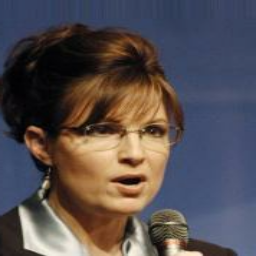

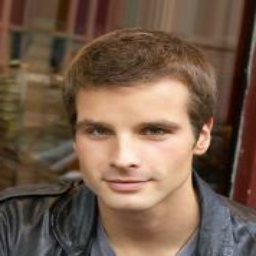

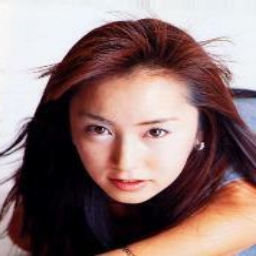

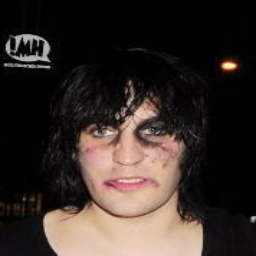

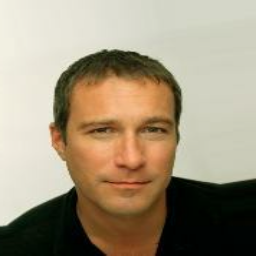

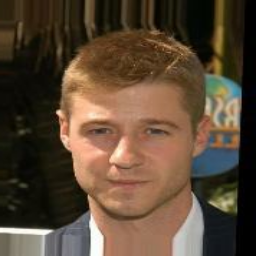

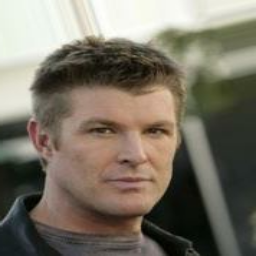

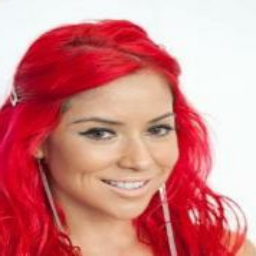

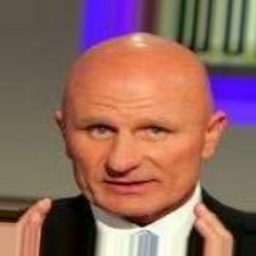

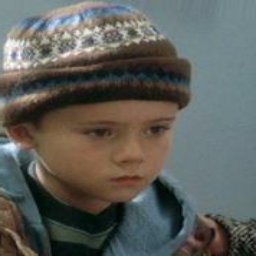

In [9]:
for batch in train_ds.take(10):
    for img in batch:
        display(array_to_img(img))

In [10]:
# resize input
def process_input(input, input_size):
    return tf.image.resize(input, [input_size, input_size], method="area")


train_ds = train_ds.map(
    lambda x: (process_input(x, lr_height), x)
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, lr_height), x)
)
valid_ds = valid_ds.prefetch(buffer_size=32)

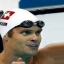

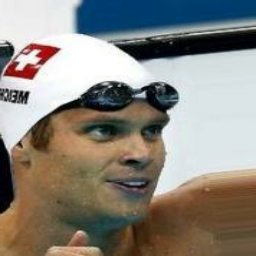

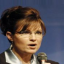

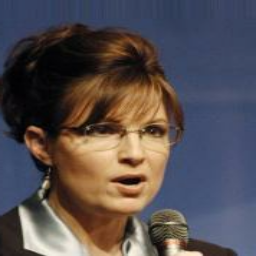

In [11]:
for batch in train_ds.take(2):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

# Set model

In [12]:
from tensorflow import keras

In [50]:
class SRGAN(keras.Model):
    def __init__(self, discriminator, generator, vgg, combined):
        super(SRGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.vgg = vgg
        self.combined = combined
        
        channels = 3
        lr_height = 64  # Low resolution height
        lr_width = 64  # Low resolution width
        lr_shape = (lr_height, lr_width, channels)
        hr_height = lr_height * 4  # High resolution height
        hr_width = lr_width * 4  # High resolution width
        hr_shape = (hr_height, hr_width, channels)
        
        patch = int(hr_height / 2**4)
        self.disc_patch = (patch, patch, 1)
        
        
    def compile(self, d_optimizer, g_optimizer):
        super(SRGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        
        self.mse = tf.keras.losses.MeanSquaredError()
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy()
        
        
    def discriminator_loss(self, real_output, fake_output):
        batch_size = 1
        
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        real_loss = self.cross_entropy(valid, real_output)
        fake_loss = self.cross_entropy(fake, fake_output)
        total_loss = 0.5 * (real_loss + fake_loss)
        
        return total_loss
    
    def generator_loss(self, imgs_lr, imgs_hr):
        v, img_f = self.combined([imgs_lr, imgs_hr])

        image_features = self.vgg(imgs_hr)
        # The generators want the discriminators to label the generated images as real
        valid = np.ones((batch_size,) + self.disc_patch)

        vgg_loss = self.mse(img_f, image_features)
        gan_loss = 1e-3 * self.cross_entropy(v, valid)
        vgg_loss = tf.dtypes.cast(vgg_loss, tf.float64)

        loss = tf.add(gan_loss, vgg_loss)

        return loss
    
    def train_step(self, data):

        imgs_lr, imgs_hr = data
        batch_size = tf.shape(imgs_lr)[0]
#         print("batch_size: ", batch_size)
        
        with tf.GradientTape() as disc_tape:
            fake_hr = self.generator(imgs_lr, training=True)

            real_output = self.discriminator(imgs_hr, training=True)
            fake_output = self.discriminator(fake_hr, training=True)
            
            psnr = tf.image.psnr(fake_hr, imgs_hr, max_val=1.0)
            ssim = tf.image.ssim(fake_hr, imgs_hr, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
        
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        
        
        with tf.GradientTape() as gen_tape:
            gen_loss = self.generator_loss(imgs_lr, imgs_hr)
        
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        
        return {"gen_loss": gen_loss, "disc_loss":disc_loss, "psnr": psnr, "ssim": ssim}

In [14]:
# optimizer = Adam(0.0002, 0.5)
generator_optimizer = Adam(0.0002, 0.5)
discriminator_optimizer = Adam(0.0002, 0.5)

df = 64
gf = 64
        
'''build vgg19'''
vgg = build_vgg()

'''build the discriminator'''
discriminator = build_discriminator(df)

'''Build the generator''' 
generator = build_generator(gf)

In [15]:
'''Build combined'''
# High res. and low res. images
img_hr = Input(shape=hr_shape)
img_lr = Input(shape=lr_shape)

# Generate high res. version from low res.
fake_hr = generator(img_lr)

# Extract image features of the generated img
fake_features = vgg(fake_hr)

# For the combined model we will only train the generator
# discriminator.trainable = False

# Discriminator determines validity of generated high res. images
validity = discriminator(fake_hr)

combined = Model([img_lr, img_hr], [validity, fake_features])

In [51]:
srgan = SRGAN(discriminator, generator, vgg, combined)

In [52]:
srgan.compile(generator_optimizer, discriminator_optimizer)

In [48]:
# srgan.fit(train_ds.take(30))
for batch in train_ds.take(3):
    srgan.train_step(batch)

In [ ]:
srgan.fit(train_ds.take(300), epochs=10, batch_size=1, verbose=1)